In [ ]:
# !pip install hottbox

In [12]:
!git clone https://github.com/mmalekzadeh/motion-sense
!unzip -d . ./motion-sense/data/A_DeviceMotion_data.zip
!ls .

Archive:  ./motion-sense/data/A_DeviceMotion_data.zip
   creating: ./A_DeviceMotion_data/
   creating: ./A_DeviceMotion_data/dws_11/
  inflating: ./A_DeviceMotion_data/dws_11/sub_12.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_1.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_13.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_11.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_2.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_3.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_10.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_14.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_7.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_6.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_15.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_17.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_4.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_5.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_16.csv  
  inflating: ./A_DeviceMotion_data/dws_11/sub_8.c

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hottbox.core import Tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error
from tqdm import tqdm
from itertools import product

используем данные акселерометра при совершении каких-то действий.
данные взяты из репозитория
https://github.com/mmalekzadeh/motion-sense/tree/master


видим, что данные 6 мерные, всего 1300 измерений. 3 координатных и 3 измерения ускорения.
Для начала применим разложение с помощью методов для разных компонент и посмотрим, какие собственные числа получаются для разных методов


In [ ]:
# "./A_DeviceMotion_data/ups_3/sub_2.csv"
def get_data(fname):
    """
    загрузка данных и приведение в нужный формат
    """
    data = pd.read_csv(fname)
    data = data.iloc[:, 1:]

    data = data.to_numpy()
    T = data.shape[0]
    new_shape = (T, 4, 3)
    data = np.reshape(data, new_shape)
    tensor_data = Tensor(data)
    return tensor_data




def iterate_ks(tensor_data, alg_name = 'hosvd'):
    """
    итерация по размерам ядра
    """
    if alg_name == 'hosvd':
        alg = HOSVD()
    else:
        alg = HOOI()

    a = product(range(1, 12), range(1, 5), range(1,4))
    errors = []
    compression_rates = []
    for i,j,k in a:
        ml_rank = (i,j,k)
        tensor_tucker = alg.decompose(tensor_data, ml_rank)

        size = np.prod(ml_rank)
        for mode, fmat in enumerate(tensor_tucker.fmat):
            size += np.prod(fmat.shape)

        error = residual_rel_error(tensor_data, tensor_tucker)
        compression_rate = size / np.prod(tensor_data.shape)
        errors.append(error)
        compression_rates.append(compression_rate)
    return errors, compression_rates



In [ ]:
folder_name = "./A_DeviceMotion_data/ups_3/" #sub_2.csv"

rez = {}
for i in tqdm(range(1, 25)):
    datapath = folder_name+f"sub_{i}.csv"
    tensor_data = get_data(datapath)
    tmp_rez = {}
    for alg_name, dot_type in zip(['hosvd', 'hooi'], [".", "+"]):
        err, comp_rate = iterate_ks(tensor_data, alg_name)
        tmp_rez["compression"] = comp_rate
        tmp_rez[alg_name] = err
    rez[i] = tmp_rez

100%|██████████| 24/24 [14:41<00:00, 36.72s/it]


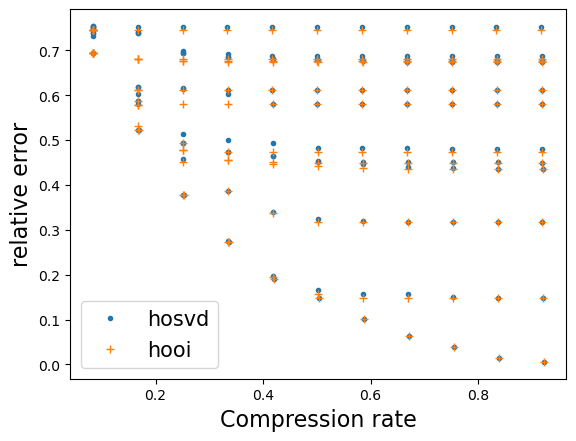

In [ ]:
a = rez[3]
for name, dot_type in zip(['hosvd', 'hooi'],['.', '+']):
    plt.plot(a['compression'], a[name], dot_type, label =name)

plt.ylabel("relative error", fontsize = 16)
plt.xlabel("Compression rate", fontsize = 16)
# plt.yscale("log")
plt.legend(fontsize = 15)

In [ ]:
df = pd.DataFrame()
for num, rezi in rez.items():
    diff = np.array(rezi['hosvd']) - np.array(rezi['hooi'])
    compression = np.array(rezi["compression"])
    df[f'diff_{num}'] = diff
    df[f'hosvd_{num}'] = np.array(rezi['hosvd'])
    df[f'hooi_{num}'] = np.array(rezi['hooi'])
    df[f'compression_{num}'] = compression
    df[f"group_{num}"] = pd.cut(df[f'compression_{num}'] , bins=np.linspace(0., 1., 11))

In [ ]:
dat = np.concatenate([df[[f"diff_{i}", f"compression_{i}", f"group_{i}"]].to_numpy() for i in range(1, df.shape[1]//5 + 1)], axis=0)
dat = pd.DataFrame(dat, columns=["diff", 'compression', 'group'])


Эксперимент с группировкой по перцентилям

In [ ]:
agg_mean = dat.groupby(by="group").mean()
agg_disp = dat.groupby(by="group").std()
display(agg_mean)
display(agg_disp)

,diff,compression
group,,
"(0.0, 0.1]",0.02674,0.084116
"(0.1, 0.2]",0.037159,0.167636
"(0.2, 0.3]",0.028148,0.251155
"(0.3, 0.4]",0.016055,0.334675
"(0.4, 0.5]",0.009464,0.418195
"(0.5, 0.6]",0.007699,0.543474
"(0.6, 0.7]",0.006143,0.668754
"(0.7, 0.8]",0.00543,0.752273
"(0.8, 0.9]",0.005037,0.835793


,diff,compression
group,,
"(0.0, 0.1]",0.035300,0.000436
"(0.1, 0.2]",0.037185,0.000575
"(0.2, 0.3]",0.028015,0.000716
"(0.3, 0.4]",0.016513,0.000857
"(0.4, 0.5]",0.011829,0.001000
"(0.5, 0.6]",0.011474,0.041814
"(0.6, 0.7]",0.010975,0.001429
"(0.7, 0.8]",0.011079,0.001572
"(0.8, 0.9]",0.011186,0.001716


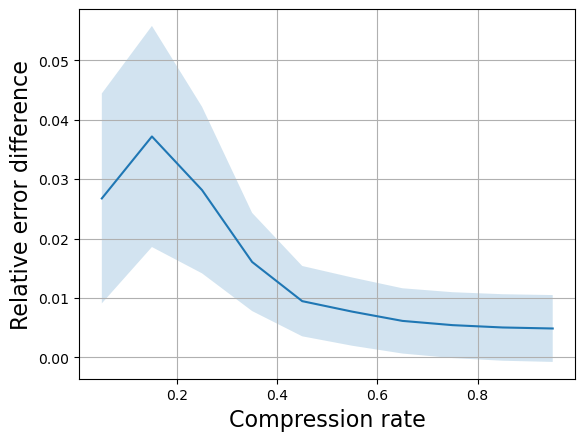

In [ ]:
x = np.array([(agg_mean.index[i].left + agg_mean.index[i].right)/2 for i in range(10)])
y = agg_mean['diff'].to_numpy(dtype=float).reshape(-1)
std = agg_disp['diff'].to_numpy(dtype=float).reshape(-1)

ax = plt.subplot()
ax.plot(x, y)
ax.fill_between(x, y - 0.5 * std, y + 0.5 * std, alpha = 0.2)
plt.xlabel("Compression rate", fontsize = 16)
plt.ylabel("Relative error difference", fontsize = 16)
plt.grid()
plt.show()

берем лучшие результаты для каждого тензора и каждого размера

In [ ]:
df2 = pd.DataFrame()
for i in range(1, df.shape[1]//5 + 1):
    tmp = df[[f"diff_{i}", f"group_{i}"]].groupby(f'group_{i}', observed=True)[f"diff_{i}"].min()
    df2[f"min_{i}"] = tmp.values
df2['worst'] = df2.max(axis=1)
df2['group'] = tmp.index
print("group worst approximation between best approximations:")
display(df2[['group', 'worst']])

group worst approximation between best approximations:


,group,worst
0,"(0.0, 0.1]",1.110223e-16
1,"(0.1, 0.2]",2.220446e-16
2,"(0.2, 0.3]",3.330669e-16
3,"(0.3, 0.4]",1.665335e-16
4,"(0.4, 0.5]",1.110223e-16
5,"(0.5, 0.6]",2.775558e-17
6,"(0.6, 0.7]",6.938894e-17
7,"(0.7, 0.8]",6.245005e-17
8,"(0.8, 0.9]",4.510281e-17
9,"(0.9, 1.0]",6.938894e-18


видим, что для лучших подобранных размеров тензора алгоритмы работают одинаково

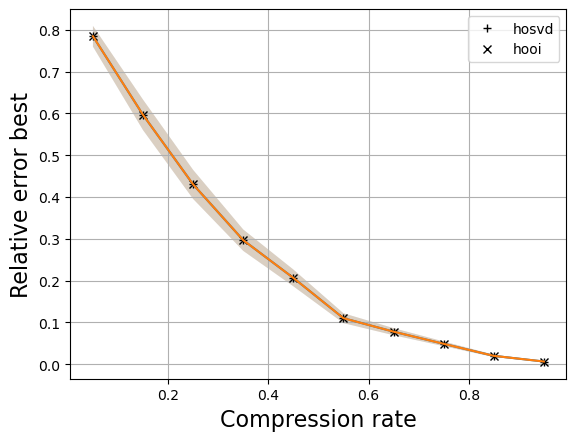

In [ ]:
for alg_name, dot_type in zip(['hosvd', 'hooi'], ["+", "x"]):
    df2 = pd.DataFrame()
    for i in range(1, df.shape[1]//5 + 1):
        tmp = df[[f"{alg_name}_{i}", f"group_{i}"]].groupby(f'group_{i}', observed=True)[f"{alg_name}_{i}"].min()
        df2[f"min_{i}"] = tmp.values
    df2['mean'] = df2.mean(axis=1)
    df2['std'] = df2.iloc[:, :-1].std(axis=1)
    df2['group'] = tmp.index


    x = np.array([(agg_mean.index[i].left + agg_mean.index[i].right)/2 for i in range(10)])
    y = df2['mean'].to_numpy(dtype=float).reshape(-1)
    std = df2['std'].to_numpy(dtype=float).reshape(-1)

    ax = plt.subplot()
    ax.plot(x, y,dot_type, color = 'black', label = alg_name)
    ax.plot(x, y)
    ax.fill_between(x, y - 0.5 * std, y + 0.5 * std, alpha = 0.2)
plt.xlabel("Compression rate", fontsize = 16)
plt.ylabel("Relative error best", fontsize = 16)
plt.grid()
plt.legend()
plt.show()